# Import necessary libraries

In [108]:
import torch
import os
import wget
import json
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt 
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from pytorch_tabnet.tab_model import TabNetRegressor
from pathlib import Path

np.random.seed(0)
sb.set() 
model = TabNetRegressor(device_name='cuda') 


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [48]:
csv_data = pd.read_csv('data/clean_data/final_data.csv')

with open('data/clean_data/encoding_mappings.json', 'r') as fp:
    encoding_mappings = json.load(fp)

final_data_after2015 = csv_data[csv_data['Year'] >= 2015]
final_data_after2015 


,Year,Month,lease_commence_date,floor_area_sqm,average_storey,resale_price_adjusted,town,flat_type,flat_model
421854,2015,1,2000,90.0,8.0,335238.026219,16,3,5
421855,2015,1,2004,90.0,5.0,334252.032025,16,3,5
421856,2015,1,2012,117.0,20.0,936694.485025,6,4,6
421857,2015,1,2012,124.0,5.0,813445.210679,6,4,6
421858,2015,1,2006,110.0,5.0,811276.023451,6,4,6
...,...,...,...,...,...,...,...,...,...
633997,2024,3,1990,105.0,2.0,538888.000000,12,3,5
633998,2024,3,1985,91.0,11.0,538000.000000,12,3,3
633999,2024,3,1978,98.0,8.0,538000.000000,12,3,3
634000,2024,3,2019,92.0,5.0,573000.000000,12,3,5


In [49]:
for category, mappings in encoding_mappings.items():
    print(f"{category}:")
    for key, value in mappings.items():
        print(f"  {key}: {value}")
    print() 

town:
  GEYLANG: 0
  ANG MO KIO: 1
  YISHUN: 2
  BEDOK: 3
  TOA PAYOH: 4
  BUKIT BATOK: 5
  QUEENSTOWN: 6
  CLEMENTI: 7
  JURONG EAST: 8
  JURONG WEST: 9
  WOODLANDS: 10
  KALLANG/WHAMPOA: 11
  HOUGANG: 12
  BUKIT PANJANG: 13
  SERANGOON: 14
  CHOA CHU KANG: 15
  SEMBAWANG: 16
  CENTRAL AREA: 17
  TAMPINES: 18
  MARINE PARADE: 19
  BUKIT MERAH: 20
  SENGKANG: 21
  PASIR RIS: 22
  PUNGGOL: 23
  BISHAN: 24
  BUKIT TIMAH: 25

flat_type:
  1 ROOM: 0
  2 ROOM: 1
  3 ROOM: 2
  4 ROOM: 3
  5 ROOM: 4
  EXECUTIVE: 5
  MULTI-GENERATION: 6

flat_model:
  Standard: 0
  2-room: 1
  Simplified: 2
  New Generation: 3
  Model A2: 4
  Model A: 5
  Improved: 6
  Premium Apartment: 7
  Adjoined flat: 8
  Apartment: 9
  Model A-Maisonette: 10
  Improved-Maisonette: 11
  Maisonette: 12
  Multi Generation: 13
  3Gen: 14
  Terrace: 15
  Premium Maisonette: 16
  DBSS: 17
  Type S1: 18
  Premium Apartment Loft: 19
  Type S2: 20



In [50]:
def encode_new_input(new_input, encoding_mappings):
# If new_input is a dictionary, convert it to a DataFrame
    if isinstance(new_input, dict):
        new_input = pd.DataFrame([new_input])
    
    # If new_input is a list of dictionaries, convert it to a DataFrame
    elif isinstance(new_input, list):
        new_input = pd.DataFrame(new_input)

    # Ensure that new_input is a DataFrame at this point
    if not isinstance(new_input, pd.DataFrame):
        raise ValueError("new_input must be a pandas DataFrame, a dictionary, or a list of dictionaries.")    
    new_input_encoded = new_input.copy()
    for column, mapping in encoding_mappings.items():
        if column in new_input.columns:
            # Apply the mapping to the column
            new_input_encoded[column] = new_input[column].map(mapping)
            # Fill in NaN values if the category was not seen during training
            if new_input_encoded[column].isna().any():
                unknown_rank = np.median(list(mapping.values()))
                # Use direct assignment instead of inplace=True
                new_input_encoded[column] = new_input_encoded[column].fillna(unknown_rank)
    
    return new_input_encoded

In [66]:
X = final_data_after2015[['Year','Month','floor_area_sqm', 'lease_commence_date', 'average_storey','town', 'flat_type', 'flat_model']]
y = final_data_after2015['resale_price_adjusted']

# Employing basic linearing regression model with the numerical data

Goodness of Fit of Model on Test Dataset:
Explained Variance (R^2): 0.643241932046551
Mean Squared Error (MSE): 11526884280.46278



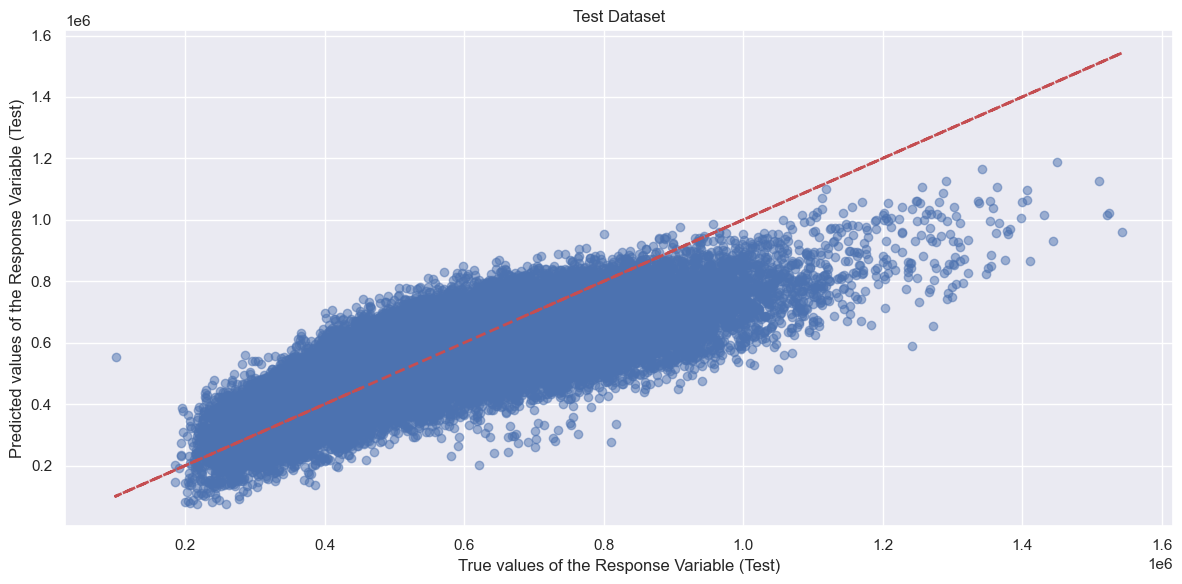

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predictions
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

print("Goodness of Fit of Model on Test Dataset:")
print("Explained Variance (R^2):", r2_score(y_test, y_test_pred))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_test_pred))
print()

# Plot the Predictions versus True values
plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha= 0.5)
plt.plot(y_test, y_test, 'r--', linewidth=2)
plt.xlabel("True values of the Response Variable (Test)")
plt.ylabel("Predicted values of the Response Variable (Test)")
plt.title("Test Dataset")

plt.tight_layout()
plt.show()

Goodness of Fit of Model on Test Dataset:
Explained Variance (R^2): 0.6976124945234461
Mean Squared Error (MSE): 0.03273088368445982



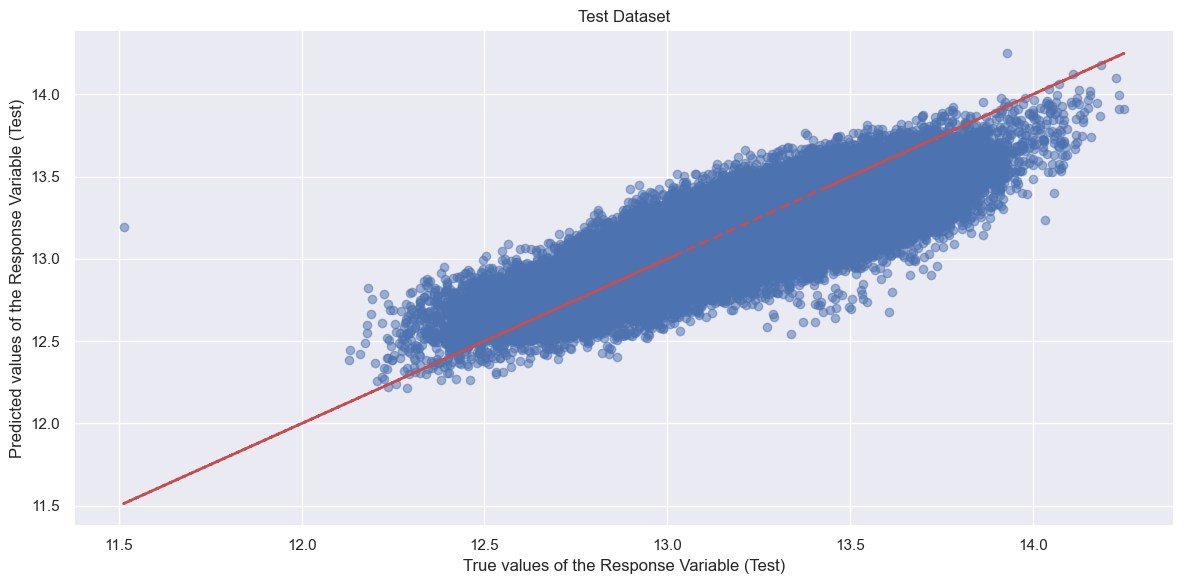

In [112]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

# Train a linear regression model
linreg_withLog = LinearRegression()
linreg_withLog.fit(X_train, y_train_log)

y_train_pred_log = linreg_withLog.predict(X_train)
y_test_pred_log = linreg_withLog.predict(X_test)

print("Goodness of Fit of Model on Test Dataset:")
print("Explained Variance (R^2):", r2_score(y_test_log, y_test_pred_log))
print("Mean Squared Error (MSE):", mean_squared_error(y_test_log, y_test_pred_log))
print()

plt.figure(figsize=(12, 6))

plt.scatter(y_test_log, y_test_pred_log, alpha=0.5)
plt.plot(y_test_log, y_test_log, 'r--', linewidth=2)
plt.xlabel("True values of the Response Variable (Test)")
plt.ylabel("Predicted values of the Response Variable (Test)")
plt.title("Test Dataset")

plt.tight_layout()
plt.show()

In [29]:
# new_sample = {
#     'floor_area_sqm': 100,
#     'lease_commence_date': 2020,
#     'average_storey': 10,
#     'town': 'ANG MO KIO',
#     'flat_type': '5 ROOM',
#     'flat_model': 'Simplified'
# }

# new_sample_df = pd.DataFrame([new_sample])

# encoded_user_input_linreg = encode_new_input(new_sample_df, encoding_mappings)

# predicted_resale_value_linreg = linreg.predict(encoded_user_input_linreg)

# print(f"Predicted Resale Value: {predicted_resale_value_linreg[0]}")

Predicted Resale Value: 547599.2887051096


# Load data and split

In [69]:
train = final_data_after2015.copy() 

if 'Set' not in train.columns:
    train.loc[:, 'Set'] = np.random.choice(["train", "valid", "test"], p=[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set == "train"].index
valid_indices = train[train.Set == "valid"].index
test_indices = train[train.Set == "test"].index

train

,Year,Month,lease_commence_date,floor_area_sqm,average_storey,resale_price_adjusted,town,flat_type,flat_model,Set
421854,2015,1,2000,90.0,8.0,335238.026219,16,3,5,train
421855,2015,1,2004,90.0,5.0,334252.032025,16,3,5,train
421856,2015,1,2012,117.0,20.0,936694.485025,6,4,6,train
421857,2015,1,2012,124.0,5.0,813445.210679,6,4,6,train
421858,2015,1,2006,110.0,5.0,811276.023451,6,4,6,train
421859,2015,1,2003,111.0,29.0,769075.471915,6,4,6,train
421860,2015,1,2001,137.0,11.0,455529.317980,16,5,7,train
421861,2015,1,2008,90.0,32.0,755271.553188,6,3,5,valid
421862,2015,1,2001,86.0,2.0,338196.008804,16,3,4,test
421863,2015,1,2006,90.0,20.0,744425.617046,6,3,5,train


In [31]:
# unused_feat = ['Set']
# categorical_columns = ['town', 'flat_type', 'flat_model'] 

# # Create a list of features to be used for training

# # Identify the index positions of categorical features in the 'features' list
# cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]

# # Compute the cardinality (number of unique values) for each categorical feature
# categorical_dims = {col: train[col].nunique() for col in categorical_columns}
# cat_dims = [categorical_dims[f] for f in features if f in categorical_columns]


# # # Define the embedding sizes for categorical features
# # cat_emb_dim = [min(50, (dim + 1) // 2) for dim in cat_dims]

# print(cat_idxs)
# print(cat_dims)
# # print(cat_emb_dim)

[3, 4, 5]
[26, 7, 21]


In [61]:
tabnetReg = TabNetRegressor()


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [72]:
features = ['Year','Month','floor_area_sqm', 'lease_commence_date', 'average_storey','town', 'flat_type', 'flat_model']
target = 'resale_price_adjusted'

X_train = train.loc[train_indices, features].values
y_train = train.loc[train_indices, target].values.reshape(-1, 1)

X_valid = train.loc[valid_indices, features].values
y_valid = train.loc[valid_indices, target].values.reshape(-1, 1)

X_test = train.loc[test_indices, features].values
y_test = train.loc[test_indices, target].values.reshape(-1, 1)

log_y_train = np.log(y_train)
log_y_valid = np.log(y_valid)
log_y_test = np.log(y_test)


In [74]:
print(log_y_test.size)
print(y_test.size)
print(X_test.shape)

X_test

21313
21313
(21313, 8)


array([[2015.,    1.,   86., ...,   16.,    3.,    4.],
       [2015.,    1.,   88., ...,    6.,    3.,    5.],
       [2015.,    1.,  121., ...,   16.,    4.,    6.],
       ...,
       [2024.,    3.,   67., ...,   12.,    2.,    3.],
       [2024.,    3.,   84., ...,   12.,    3.,    2.],
       [2024.,    3.,  105., ...,   12.,    3.,    5.]])

In [84]:
# Fit the TabNetRegressor on the training data
max_epochs = 200

tabnetReg.fit(
    X_train, log_y_train,
    eval_set=[(X_train, log_y_train), (X_valid, log_y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['rmse'],
    max_epochs=max_epochs,
    patience=20,
    batch_size=2048*2,
    virtual_batch_size=128*2*2,
    num_workers=0,
    drop_last=False
)


epoch 0  | loss: 42.89316| train_rmse: 33.43285| valid_rmse: 34.22939|  0:00:15s
epoch 1  | loss: 0.18522 | train_rmse: 0.52681 | valid_rmse: 0.52601 |  0:00:29s
epoch 2  | loss: 0.07879 | train_rmse: 0.27113 | valid_rmse: 0.27136 |  0:00:43s
epoch 3  | loss: 0.06221 | train_rmse: 0.27004 | valid_rmse: 0.27022 |  0:01:02s
epoch 4  | loss: 0.06812 | train_rmse: 0.2809  | valid_rmse: 0.28095 |  0:01:15s
epoch 5  | loss: 0.05656 | train_rmse: 0.24908 | valid_rmse: 0.24926 |  0:01:28s
epoch 6  | loss: 0.04401 | train_rmse: 0.23924 | valid_rmse: 0.2396  |  0:01:41s
epoch 7  | loss: 0.04042 | train_rmse: 4.33787 | valid_rmse: 4.36786 |  0:01:54s
epoch 8  | loss: 0.04585 | train_rmse: 0.97056 | valid_rmse: 0.97723 |  0:02:07s
epoch 9  | loss: 0.0424  | train_rmse: 0.88196 | valid_rmse: 0.88619 |  0:02:22s
epoch 10 | loss: 0.03593 | train_rmse: 0.62116 | valid_rmse: 0.62804 |  0:02:39s
epoch 11 | loss: 0.03476 | train_rmse: 0.27804 | valid_rmse: 0.27997 |  0:02:52s
epoch 12 | loss: 0.03409 | t

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


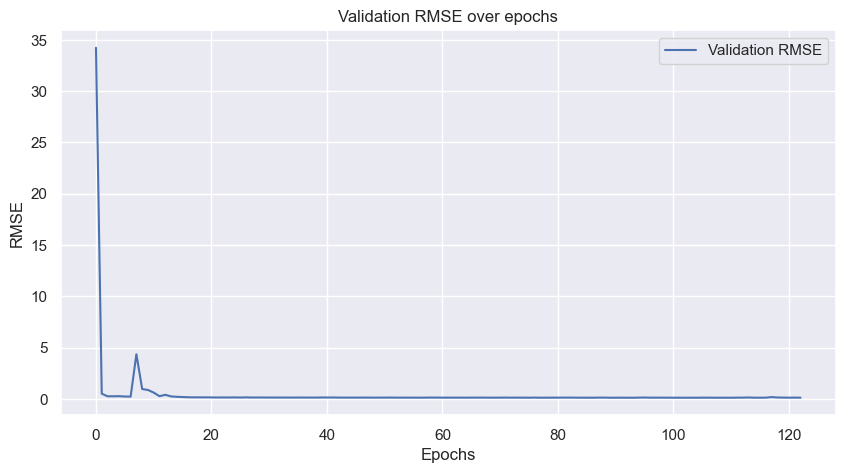

In [85]:
valid_rmse = tabnetReg.history['valid_rmse']

epochs = range(len(valid_rmse))

plt.figure(figsize=(10,5))
plt.plot(epochs, valid_rmse, label='Validation RMSE')
plt.title('Validation RMSE over epochs')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [92]:
# Predict and evaluate the model on the test set
predictions = tabnetReg.predict(X_test)

# Calculate RMSE for the test set predictions
rmse = np.sqrt(mean_squared_error(log_y_test, predictions))
print(f"RMSE on test set: {rmse}")

RMSE on test set: 0.12910223507132895


Goodness of Fit of Model on Test Dataset:
Explained Variance (R^2): 0.844485555482071
Mean Squared Error (MSE): 0.016667387100412677



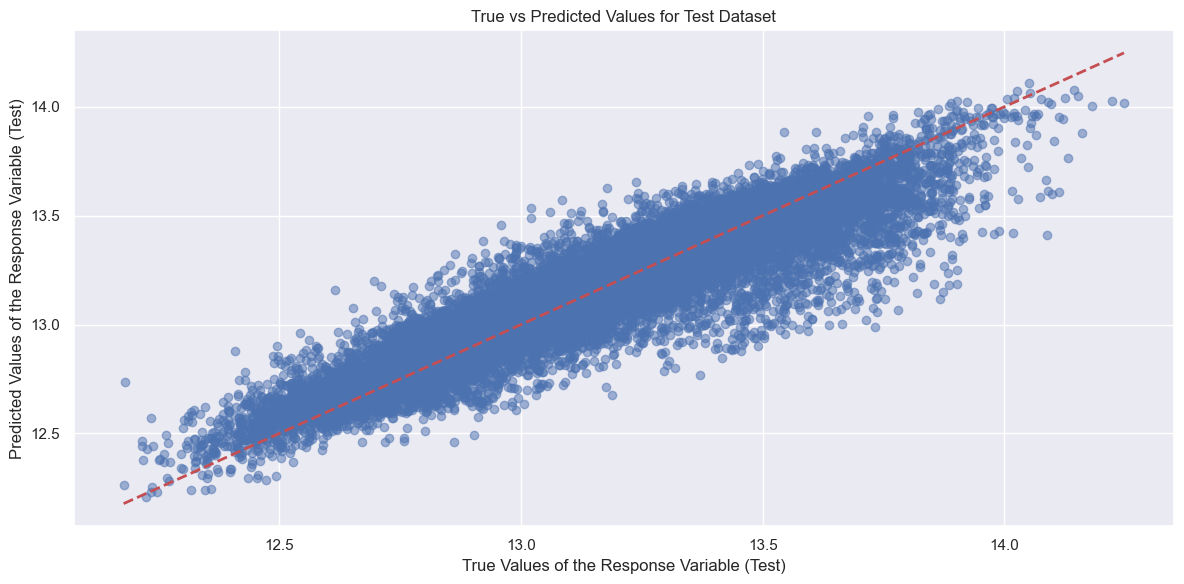

In [93]:

plt.figure(figsize=(12, 6))

print("Goodness of Fit of Model on Test Dataset:")
print("Explained Variance (R^2):", r2_score(log_y_test, predictions))
print("Mean Squared Error (MSE):", mean_squared_error(log_y_test, predictions))
print()

# Scatter plot for actual vs predicted values
plt.scatter(log_y_test, predictions, alpha=0.5)

# Plot the diagonal line, which represents the perfect predictions
plt.plot([min(log_y_test), max(log_y_test)], [min(log_y_test), max(log_y_test)], 'r--', linewidth=2)

plt.xlabel("True Values of the Response Variable (Test)")
plt.ylabel("Predicted Values of the Response Variable (Test)")
plt.title("True vs Predicted Values for Test Dataset")

plt.tight_layout()
plt.show()

In [99]:
for category, mappings in encoding_mappings.items():
    print(f"{category}:")
    for key, value in mappings.items():
        print(f"  {key}: {value}")
    print() 
    
train

town:
  GEYLANG: 0
  ANG MO KIO: 1
  YISHUN: 2
  BEDOK: 3
  TOA PAYOH: 4
  BUKIT BATOK: 5
  QUEENSTOWN: 6
  CLEMENTI: 7
  JURONG EAST: 8
  JURONG WEST: 9
  WOODLANDS: 10
  KALLANG/WHAMPOA: 11
  HOUGANG: 12
  BUKIT PANJANG: 13
  SERANGOON: 14
  CHOA CHU KANG: 15
  SEMBAWANG: 16
  CENTRAL AREA: 17
  TAMPINES: 18
  MARINE PARADE: 19
  BUKIT MERAH: 20
  SENGKANG: 21
  PASIR RIS: 22
  PUNGGOL: 23
  BISHAN: 24
  BUKIT TIMAH: 25

flat_type:
  1 ROOM: 0
  2 ROOM: 1
  3 ROOM: 2
  4 ROOM: 3
  5 ROOM: 4
  EXECUTIVE: 5
  MULTI-GENERATION: 6

flat_model:
  Standard: 0
  2-room: 1
  Simplified: 2
  New Generation: 3
  Model A2: 4
  Model A: 5
  Improved: 6
  Premium Apartment: 7
  Adjoined flat: 8
  Apartment: 9
  Model A-Maisonette: 10
  Improved-Maisonette: 11
  Maisonette: 12
  Multi Generation: 13
  3Gen: 14
  Terrace: 15
  Premium Maisonette: 16
  DBSS: 17
  Type S1: 18
  Premium Apartment Loft: 19
  Type S2: 20



,Year,Month,lease_commence_date,floor_area_sqm,average_storey,resale_price_adjusted,town,flat_type,flat_model,Set
421854,2015,1,2000,90.0,8.0,335238.026219,16,3,5,train
421855,2015,1,2004,90.0,5.0,334252.032025,16,3,5,train
421856,2015,1,2012,117.0,20.0,936694.485025,6,4,6,train
421857,2015,1,2012,124.0,5.0,813445.210679,6,4,6,train
421858,2015,1,2006,110.0,5.0,811276.023451,6,4,6,train
...,...,...,...,...,...,...,...,...,...,...
633997,2024,3,1990,105.0,2.0,538888.000000,12,3,5,test
633998,2024,3,1985,91.0,11.0,538000.000000,12,3,3,valid
633999,2024,3,1978,98.0,8.0,538000.000000,12,3,3,train
634000,2024,3,2019,92.0,5.0,573000.000000,12,3,5,train


In [116]:
new_sample = {
    'Year': 2022, #'Year' and 'Month' represent when the user wants to sell the hdb
    'Month': 2,
    'floor_area_sqm': 143,
    'lease_commence_date': 2021,
    'average_storey': 10,
    'town': 'JURONG WEST',
    'flat_type': '5 ROOM',
    'flat_model': 'Apartment'
}

new_sample_df = pd.DataFrame([new_sample])

encoded_user_input = encode_new_input(new_sample, encoding_mappings)
encoded_user_input_array = encoded_user_input.to_numpy()

#annoying coz clf.predict take in array but linreg.predict take in df
predicted_resale_price_tabnet = np.exp(tabnetReg.predict(encoded_user_input_array))
predicted_resale_price_linreg = linreg.predict(encoded_user_input)
predicted_resale_price_linreg_withLog = np.exp(linreg_withLog.predict(encoded_user_input))

print(f"Predicted Resale Value for tabnet:                      {predicted_resale_price_tabnet[0]}")
print(f"Predicted Resale Value for linreg:                      {predicted_resale_price_linreg[0]}")
print(f"Predicted Resale Value for linreg with transformation:  {predicted_resale_price_linreg_withLog[0]}")

Predicted Resale Value for tabnet:                      [840247.56]
Predicted Resale Value for linreg:                      808622.6407907978
Predicted Resale Value for linreg with transformation:  871575.7715724985
